In [26]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
import comet_ml
import pytorch_lightning as pl
import torch
from pytorch_lightning.loggers import CometLogger

from opf.dataset import CaseDataModule
from opf.modules import OPFLogBarrier, GNN
from opf.utils import graph_info
%aimport opf

In [28]:
# constants
data_dir = "../data"

# parameters that should be saved for logging
param = dict(
    case_name="case30",
    A_scaling=300,
    A_threshold=0.01,
    model="selection",
    batch_size=128,
    num_workers=8,
    pin_memory=True
)
dm = CaseDataModule(
    param["case_name"],
    data_dir=data_dir,
    batch_size=param["batch_size"],
    ratio_train=0.8
)

Non-zero edges: 82
Connected components: 1


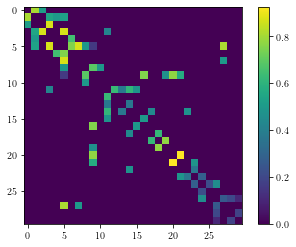

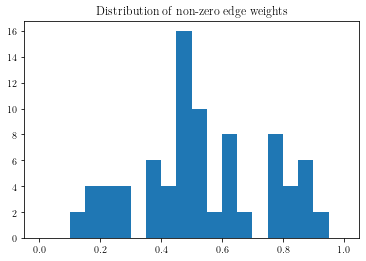

Non-zero edges: 82
Connected components: 1


In [29]:
# Choose scaling factor so that the mean weight is 0.5
param["A_scaling"] = 2 * np.exp(-1) / np.mean(dm.net_wrapper.impedence_matrix().data)
adjacency = dm.adjacency(param["A_scaling"], param["A_threshold"])
graph_info(adjacency, plot=True)
# Normalize GSO by dividing by larget eigenvalue
gso = adjacency / np.max(np.real(np.linalg.eigh(adjacency)[0]))

adjacency = dm.adjacency(param["A_scaling"], param["A_threshold"])
graph_info(adjacency)
# Normalize GSO by dividing by larget eigenvalue
gso = adjacency / np.max(np.real(np.linalg.eigh(adjacency)[0]))


In [30]:
gnn = GNN(
    gso,
    [2, 64],
    [4],
    [4 * dm.size(1)]
).float()

barrier = OPFLogBarrier(
    dm.net_wrapper,
    gnn,
    t=200,
    s=100,
    cost_weight=1.0,
    type="relaxed_log",
).float()

In [35]:
logger = CometLogger(workspace="damowerko", project_name="opf", save_dir="../logs", display_summary_level=0)
logger.log_hyperparams(param)
logger.experiment.log_code(folder="../src")
logger.experiment.log_code(folder="../scripts")

trainer = pl.Trainer(logger=logger,
                     progress_bar_refresh_rate=1,
                     gpus=1,
                     max_epochs=1000)
trainer.fit(barrier, dm)
trainer.test(datamodule=dm)
trainer.save_checkpoint("latest.ckpt")
logger.experiment.end()

CometLogger will be initialized in online mode
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/damowerko/opf/3341e6d575454ae88f8b5fbd305c141d

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GNN  | 231 K 
-------------------------------
231 K     Trainable params
0         Non-trainable params
231 K     Total params
0.924     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\damow\.virtualenvs\opf-1S7-sVgk-py3.8\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: Set model graph ignored; already called. Call with overwrite=True to replace graph definition


Testing: 0it [00:00, ?it/s]

COMET ERROR: Error sending a notification, make sure you have opted-in for notifications


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_cost': -1.7786635160446167,
 'test_equality_loss': 93.1901626586914,
 'test_equality_powerflow_loss': 69.49614715576172,
 'test_equality_reactive_power_loss': 8.086933135986328,
 'test_equality_real_power_loss': 12.030430793762207,
 'test_equality_reference_loss': 2.734255313873291,
 'test_equality_voltage_angle_difference_loss': nan,
 'test_equality_voltage_magnitude_loss': 0.8423852920532227,
 'test_inequality_backward_rate_max_loss': 1.606850266456604,
 'test_inequality_backward_rate_max_violated_rate': 0.0008630885276943445,
 'test_inequality_backward_rate_max_violated_rms': 0.01622183434665203,
 'test_inequality_forward_rate_max_loss': -0.017574140802025795,
 'test_inequality_forward_rate_max_violated_rate': 0.0,
 'test_inequality_forward_rate_max_violated_rms': 0.0,
 'test_inequality_loss': 123.63619995117188,
 'test_inequality_reactive_power_max_loss': -0.02053239382

COMET INFO: Uploading 1 metrics, params and output messages


In [16]:
# Load model
checkpoint = torch.load("latest.ckpt", map_location=lambda storage, loc: storage)
barrier.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [19]:
barrier.to("cpu")

dm.setup("test")
data = list(dm.test_dataloader())
load, gen = data[0]

with torch.no_grad():
    bus, load = barrier(load)
    V, S, Sg, Sd = barrier.bus(bus, load)
    If, It, Sf, St, Sbus = barrier.power_flow(V)

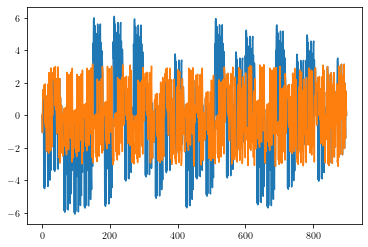

In [28]:
from IPython.display import JSON
import matplotlib.pyplot as plt

#display(JSON(barrier.pm))
diff = V.angle() + V.conj().angle().transpose(-1,-2)
mult = (V @ V.conj().transpose(-1, -2)).angle()

plt.figure()
plt.plot(diff.numpy().flat)
plt.plot(mult.numpy().flat)
plt.show()
# plt.figure()
# value = V.matmul(V.conj().transpose(-1,-2))
# ub = barrier.vad_max
# lb = barrier.vad_min
# mask = ~ub.isinf() & ~lb.isinf()
#
# plt.plot(value.squeeze()[mask].detach().numpy().flat)
# plt.plot(ub[mask].squeeze().detach().numpy().flat)
# plt.plot(lb[mask].squeeze().detach().numpy().flat)
# plt.legend(["value", "max", "min"])
# plt.show()